# Analyze data from education systems

In [1]:
from math import prod
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

## Methods cell

In [2]:
def df_initial_analysis(df, name_df):
    """
    Initial analysis on the DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame to analyze.
        name_df (str): DataFrame name.

    Returns:
        None.
        Print the initial analysis on the DataFrame. 
    """
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["Name", "Type"])
        df_resume["Records"] = list(df.count())
        
        print("\nInitial Analysis of", name_df, "dataset")
        print("--------------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty columns:        ", len(empty_cols))
        print(" + The empty column is:          ", empty_cols) if len(empty_cols) == 1 \
            else (print(" + The empty column are:          ", empty_cols) if len(empty_cols) >= 1 else None)
        print("\n- Type object and records by columns")
        print("--------------------------------------------------------------------------")
        print(df_resume.sort_values("Records", ascending=False))


def comparison_dfs(df_original, df_copy):
    """
    Create a DataFrame based on comparación between the original DataFrame and the copy DataFrame.
    Args:
        df_original (pandas.DataFrame): DataFrame original.
        df_copy (pandas.DataFrame): DataFrame copy.
    Returns:
        df_comparison (pandas.DataFrame): DataFrame comparison.
    """
    df_comparison = pd.DataFrame({
        "Moment" : ["Before", "After"],
        "Total values" : [prod(df_original.shape), prod(df_copy.shape)], 
        "Valid values" : [(prod(df_original.shape)-df_original.isna().sum().sum()), (prod(df_copy.shape)-df_copy.isna().sum().sum())],
        "Missing values" : [df_original.isna().sum().sum(), df_copy.isna().sum().sum()]
    })
    return df_comparison


def remove_columns_by_percentage_of_nan_values(df):
    """
    Remove columns in DataFrame based on percentage of NaN values in columns.
    Args:
        df (pandas.DataFrame): DataFrame to work.
    Returns:
        df (pandas.DataFrame): DataFrame worked.
    """
    percentage = 50 # Removing columns with more than 50% NaN values 

    for col in df.columns:
        if round(((df.shape[0] - df[col].count()) / df.shape[0]) * 100, 2) > percentage:
            print("- The column",  df[col].name, "has been removed.")
            df.drop([col], axis=1, inplace=True)

    return df

## Loading data

In [3]:
# loading Dataset and removing the empty columns (the empty columns, unnamed, etc.)
country = pd.read_csv("datasets/EdStatsCountry.csv")
serie = pd.read_csv("datasets/EdStatsSeries.csv")
country_serie = pd.read_csv("datasets/EdStatsCountry-Series.csv")
foot_note = pd.read_csv("datasets/EdStatsFootNote.csv")
data = pd.read_csv("datasets/EdStatsData.csv")

## Initial data analysis
- Knowing the entities of the datasets.<br>

    - **Country** dataset **`"EdStatsCountry.csv"`**.<br>
    Des renseignements en général sur l'économie de chaque pays du monde.
    
    - **Serie** dataset **`"EdStatsSeries.csv"`**.<br>
    Des renseignements en peu plus de détails sur les indicateurs économiques.
    
    - **Country-Serie** dataset **`"EdStatsCountry-Series.csv"`**.<br>
    La source des données sur l'information relationnelle entre **`"EdStatsCountry.csv"`** et **`"EdStatsSeries.csv"`**.

    - **Foot Note** dataset **`"EdStatsFootNote.csv"`**.<br>
    L’année d’origine des données et aussi une description sur les indicateurs.

    - **Data** dataset **`"EdStatsData.csv"`**.<br>
    Le dataset principal qui contient en détails le renseignement sur les indicateurs par an.

- Entity relationship diagram.<br>
<br>Il existe une relation entre les datasets à travers les colonnes **`"Country Code"`** et **`"Series Code"`** principalement.
![Entity relationship diagram](img/entity_relationship.png)

### **`"Country"`** dataset

In [4]:
country.head(3)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN


In [5]:
# Describing the numeric columns
country.describe()

,National accounts reference year,Latest industrial data,Latest trade data,Unnamed: 31
count,32.00000,107.000000,185.000000,0.0
mean,2001.53125,2008.102804,2010.994595,NaN
std,5.24856,2.616834,2.569675,NaN
min,1987.00000,2000.000000,1995.000000,NaN
25%,1996.75000,2007.500000,2011.000000,NaN
50%,2002.00000,2009.000000,2012.000000,NaN
75%,2005.00000,2010.000000,2012.000000,NaN
max,2012.00000,2010.000000,2012.000000,NaN


In [6]:
# Resume of dataset
df_initial_analysis(country, "country")


Initial Analysis of country dataset
--------------------------------------------------------------------------
- Dataset shape:                  241 rows and 32 columns
- Total of NaN values:            2354
- Percentage of NaN:              30.52 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 31']

- Type object and records by columns
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      241
3                                           Long Name   object      241
1                                          Short Name   object      241
2                                          Table Name   object      241
9                                           WB-2 code   object      240
4                                        2-alpha code   object      238
5         

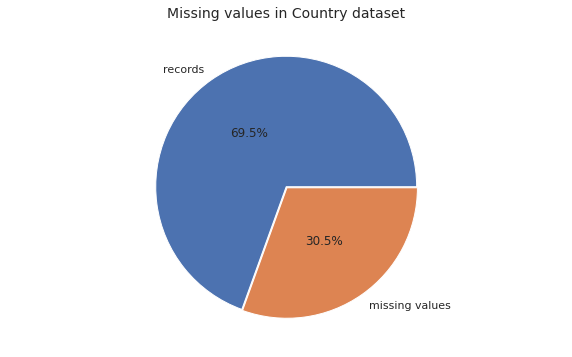

In [7]:
# Drawing missing values in Country dataset
labels = ["records", "missing values"]
vals = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Country dataset", fontsize=14)
plt.show()

### **`"Serie"`** dataset

In [8]:
serie.head(3)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15-19 with...,Percentage of female population age 15-19 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 ...,Percentage of population age 15-19 with no edu...,Percentage of population age 15-19 with no edu...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15+ with n...,Percentage of female population age 15+ with n...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Describing the numeric columns
serie.describe()

,Unit of measure,Notes from original source,Other web links,Related indicators,License Type,Unnamed: 20
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Resume of dataset
df_initial_analysis(serie, "serie")


Initial Analysis of serie dataset
--------------------------------------------------------------------------
- Dataset shape:                  3665 rows and 21 columns
- Total of NaN values:            55203
- Percentage of NaN:              71.72 %
- Total of full duplicates rows:  0
- Total of empty columns:         6
 + The empty column are:           ['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']

- Type object and records by columns
--------------------------------------------------------------------------
                                   Name     Type  Records
0                           Series Code   object     3665
13                               Source   object     3665
2                        Indicator Name   object     3665
4                       Long definition   object     3665
1                                 Topic   object     3665
3                      Short definition   object     2156
8

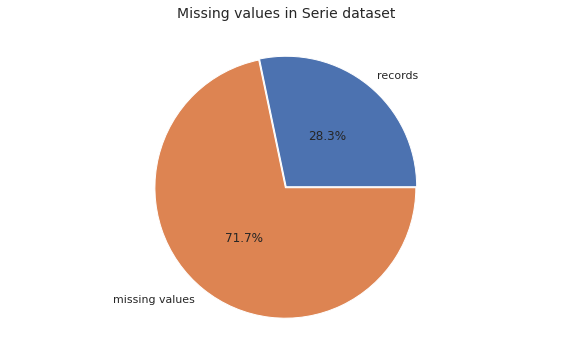

In [11]:
# Drawing missing values in Serie dataset
labels = ["records", "missing values"]
vals = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Serie dataset", fontsize=14)
plt.show()

### **`"Country-Serie"`** dataset

In [12]:
country_serie.head(3)

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN


In [13]:
# Resume of dataset
df_initial_analysis(country_serie, "country_serie")


Initial Analysis of country_serie dataset
--------------------------------------------------------------------------
- Dataset shape:                  613 rows and 4 columns
- Total of NaN values:            613
- Percentage of NaN:              25.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 3']

- Type object and records by columns
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object      613
1   SeriesCode   object      613
2  DESCRIPTION   object      613
3   Unnamed: 3  float64        0


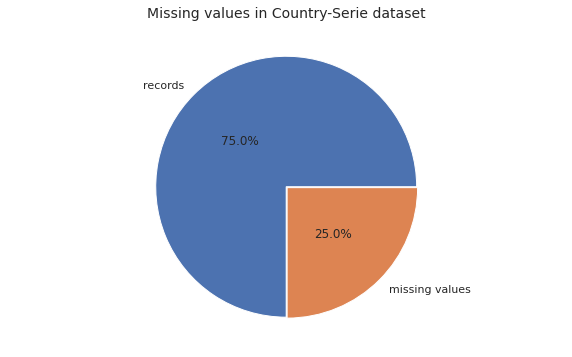

In [14]:
# Drawing missing values in Country-Serie dataset
labels = ["records", "missing values"]
vals = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Country-Serie dataset", fontsize=14)
plt.show()

### **`"Foot Note"`** dataset

In [15]:
foot_note.head(3)

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN


In [16]:
# Describing the numeric columns
foot_note.describe()

,Unnamed: 4
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [17]:
# Resume of dataset
df_initial_analysis(foot_note, "foot_note")


Initial Analysis of foot_note dataset
--------------------------------------------------------------------------
- Dataset shape:                  643638 rows and 5 columns
- Total of NaN values:            643638
- Percentage of NaN:              20.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 4']

- Type object and records by columns
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object   643638
1   SeriesCode   object   643638
2         Year   object   643638
3  DESCRIPTION   object   643638
4   Unnamed: 4  float64        0


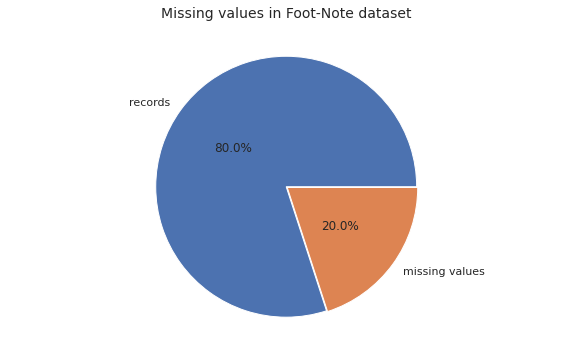

In [18]:
# Drawing missing values in Foot Note dataset
labels = ["records", "missing values"]
vals = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Foot-Note dataset", fontsize=14)
plt.show()

In [19]:
### **`"Data"`** dataset

In [20]:
data.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Describing the numeric columns
data.describe()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
count,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,3.748300e+04,3.757400e+04,3.757600e+04,3.680900e+04,...,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,0.0
mean,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,5.731808e+09,6.124437e+09,6.671489e+09,7.436724e+09,...,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02,NaN
std,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,2.215546e+11,2.325489e+11,2.473986e+11,2.660957e+11,...,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04,NaN
min,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,-2.950945e+00,-3.174870e+00,-3.558749e+00,-2.973612e+00,...,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01,NaN
25%,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,9.312615e+00,9.519913e+00,1.000000e+01,1.000000e+01,...,3.000000e-02,3.000000e-02,2.000000e-02,2.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,NaN
50%,6.317724e+00,6.316240e+01,6.655139e+01,6.969595e+01,7.087760e+01,9.677420e+00,7.101590e+01,7.133326e+01,7.290512e+01,7.510173e+01,...,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.200000e-01,NaN
75%,6.251250e+01,5.655200e+04,5.863650e+04,6.202900e+04,6.383675e+04,7.854163e+01,5.682800e+04,5.739175e+04,5.940425e+04,6.411500e+04,...,7.505000e+00,7.500000e+00,7.300000e+00,7.100000e+00,6.722500e+00,6.080000e+00,5.462500e+00,4.680000e+00,4.032500e+00,NaN
max,1.903929e+13,1.986457e+13,2.100916e+13,2.238367e+13,2.282991e+13,2.300634e+13,2.424128e+13,2.521383e+13,2.622101e+13,2.730873e+13,...,2.951569e+06,3.070879e+06,3.169711e+06,3.246239e+06,3.301586e+06,3.337871e+06,3.354746e+06,3.351887e+06,3.330484e+06,NaN


In [22]:
# Resume of dataset
df_initial_analysis(data, "data")


Initial Analysis of data dataset
--------------------------------------------------------------------------
- Dataset shape:                  886930 rows and 70 columns
- Total of NaN values:            53455179
- Percentage of NaN:              86.1 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 69']

- Type object and records by columns
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   886930
2   Indicator Name   object   886930
3   Indicator Code   object   886930
1     Country Code   object   886930
44            2010  float64   242442
..             ...      ...      ...
7             1973  float64    35545
5             1971  float64    35537
50            2016  float64    16460
51            2017  float64      143
69     Unnamed: 69  float64        0

[70 rows x 3 columns]


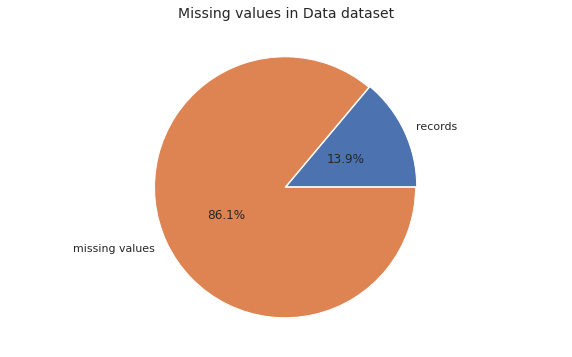

In [23]:
# Drawing missing values in Data dataset
labels = ["records", "missing values"]
vals = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Data dataset", fontsize=14)
plt.show()

## Data cleanup
- Creating copies from all datasets.
- Deleting empty columns and empty rows.
- Filtring by list of **`"countries"`** as given in **`"ISO 3166-1"`** and the corresponding **`"ISO 3166-1-alpha-2"`** code elements.<br>
https://datahub.io/core/country-list#resource-data

### Loading data and removing empty columns and empty rows

In [24]:
country_copy = country.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
serie_copy = serie.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
country_serie_copy = country_serie.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
foot_note_copy = foot_note.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
data_copy = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

### Comparing datasets before and after removing empty columns/rows

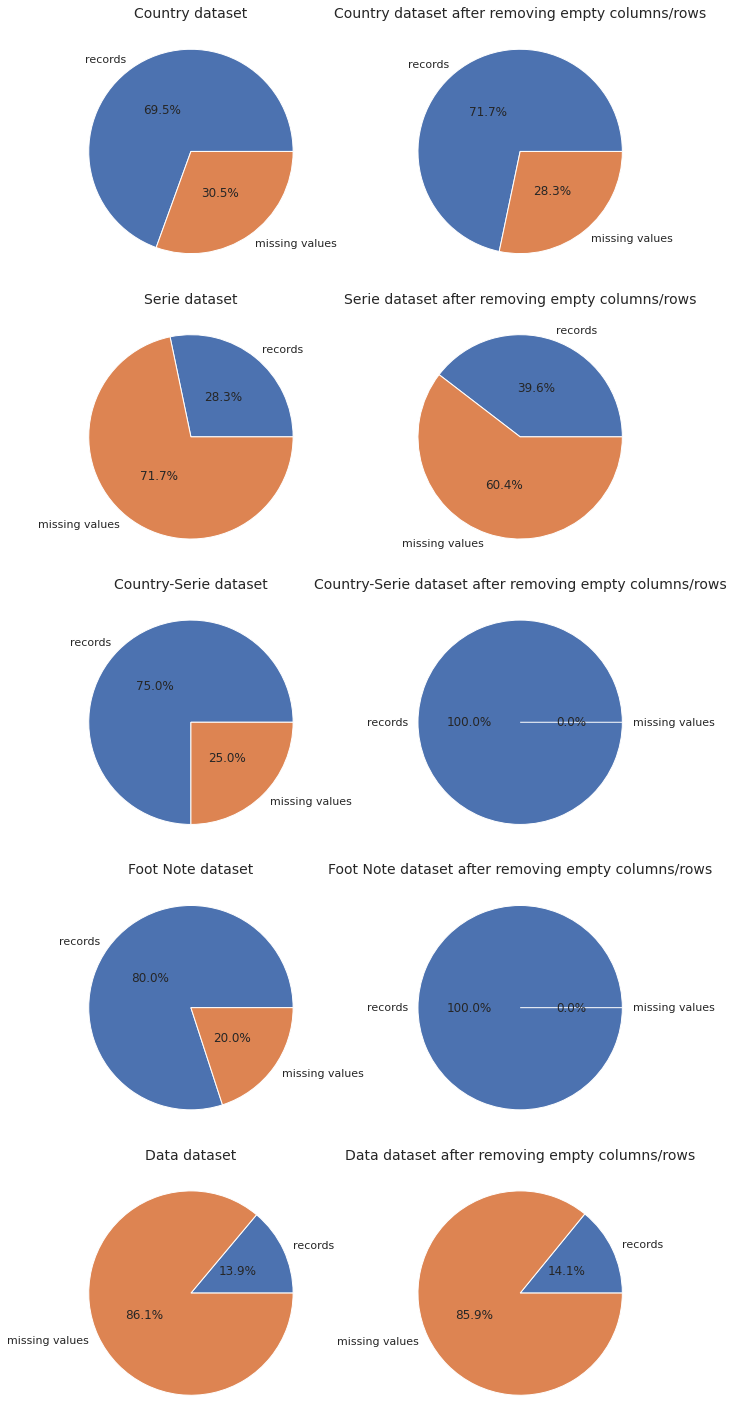

In [25]:
# Comparing missing values in all datasets before and after removing empty columns/rows
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country dataset", fontsize=14)

vals_ax2 = [prod(country_copy.shape)-country_copy.isna().sum().sum(), country_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country dataset after removing empty columns/rows", fontsize=14)

vals_ax3 = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
ax3.pie(x=vals_ax3, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax3.set_title("Serie dataset", fontsize=14)

vals_ax4 = [prod(serie_copy.shape)-serie_copy.isna().sum().sum(), serie_copy.isna().sum().sum()]
ax4.pie(x=vals_ax4, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax4.set_title("Serie dataset after removing empty columns/rows", fontsize=14)

vals_ax5 = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
ax5.pie(x=vals_ax5, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax5.set_title("Country-Serie dataset", fontsize=14)

vals_ax6 = [prod(country_serie_copy.shape)-country_serie_copy.isna().sum().sum(), country_serie_copy.isna().sum().sum()]
ax6.pie(x=vals_ax6, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax6.set_title("Country-Serie dataset after removing empty columns/rows", fontsize=14)

vals_ax7 = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
ax7.pie(x=vals_ax7, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax7.set_title("Foot Note dataset", fontsize=14)

vals_ax8 = [prod(foot_note_copy.shape)-foot_note_copy.isna().sum().sum(), foot_note_copy.isna().sum().sum()]
ax8.pie(x=vals_ax8, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax8.set_title("Foot Note dataset after removing empty columns/rows", fontsize=14)

vals_ax9 = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
ax9.pie(x=vals_ax9, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax9.set_title("Data dataset", fontsize=14)

vals_ax10 = [prod(data_copy.shape)-data_copy.isna().sum().sum(), data_copy.isna().sum().sum()]
ax10.pie(x=vals_ax10, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax10.set_title("Data dataset after removing empty columns/rows", fontsize=14)

plt.tight_layout()
plt.show()

### Comparing **`"Country"`** dataset before and after removing empty columns/rows

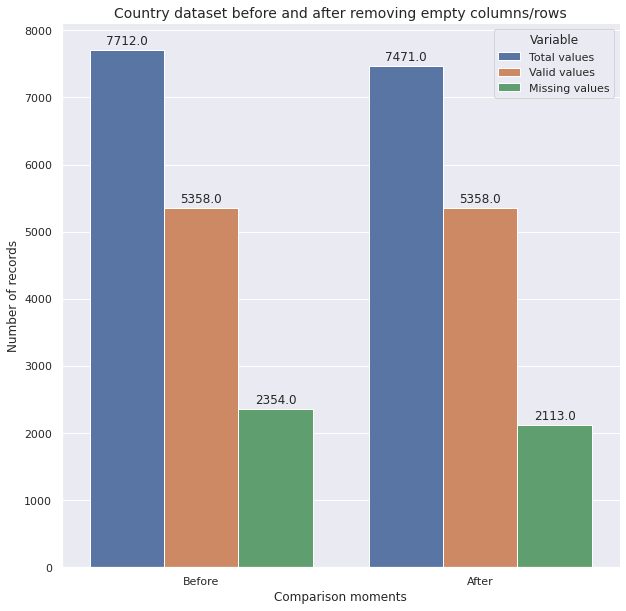

In [26]:
df_comparison = comparison_dfs(country, country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Serie"`** dataset before and after removing empty columns/rows

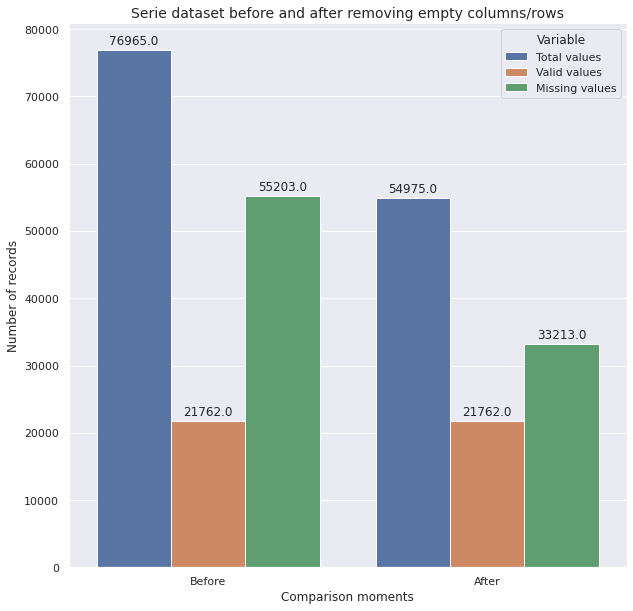

In [27]:
df_comparison = comparison_dfs(serie, serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Serie dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Country-Serie"`** dataset before and after removing empty columns/rows

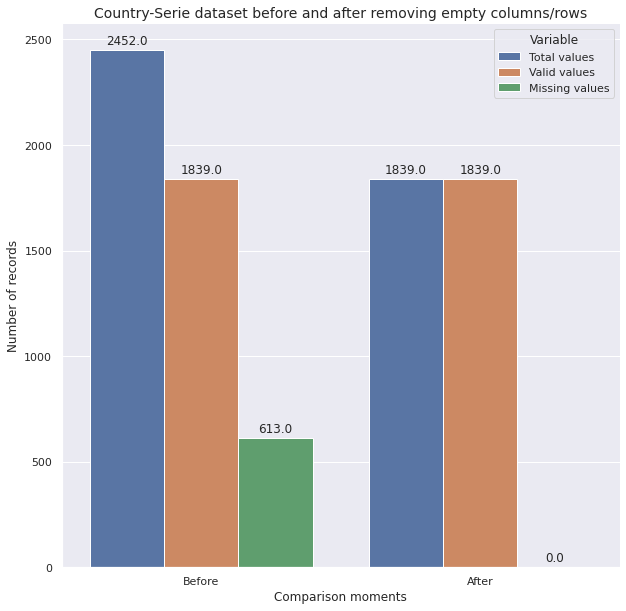

In [28]:
df_comparison = comparison_dfs(country_serie, country_serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country-Serie dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"FootNote"`** dataset before and after removing empty columns/rows

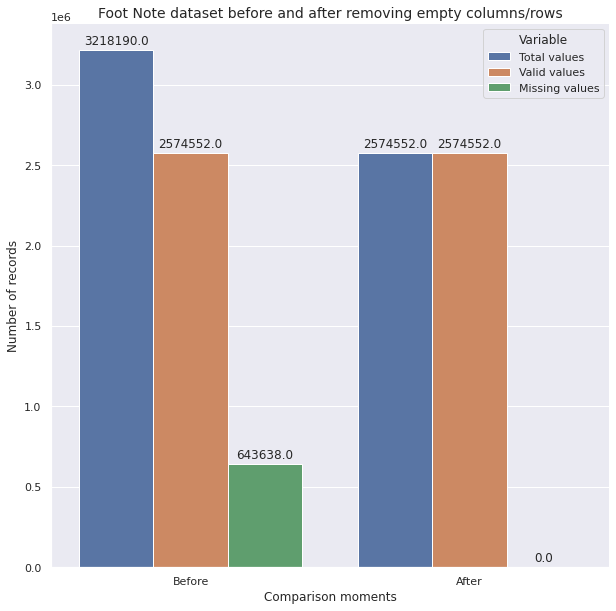

In [29]:
df_comparison = comparison_dfs(foot_note, foot_note_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Foot Note dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Data"`** dataset before and after removing empty columns/rows

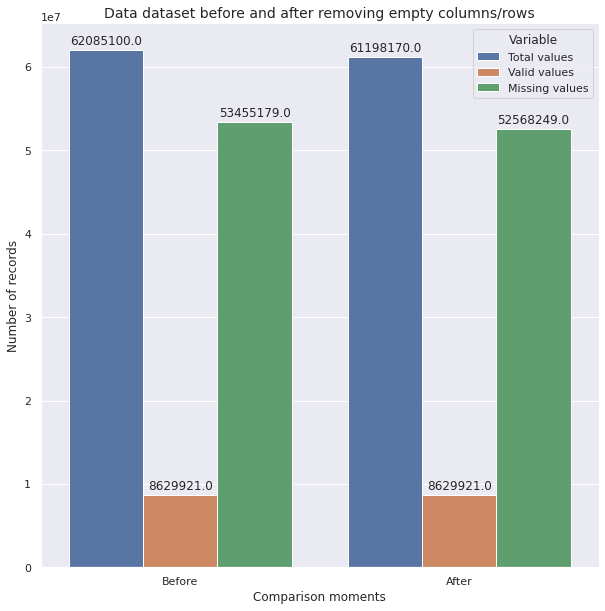

In [30]:
df_comparison = comparison_dfs(data, data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Data dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Cleaning **`"Country"`** dataset

In [31]:
# List of countries as given in ISO 3166-1 and the corresponding ISO 3166-1-alpha-2 code elements.  
countries_iso = pd.read_csv("datasets/countries_ISO.csv", sep=",", 
                            keep_default_na=False, encoding="utf-8") # Avoiding that "NA" will be interpreted as NaN by Pandas

In [32]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = country_copy[~country_copy["2-alpha code"].isin(countries_iso["Code"])]
df_print

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
5,ARB,Arab World,Arab World,Arab World,1A,NaN,Arab World aggregate. Arab World is composed o...,NaN,NaN,1A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,CHI,Channel Islands,Channel Islands,Channel Islands,NaN,Pound sterling,NaN,Europe & Central Asia,High income: nonOECD,JG,...,NaN,NaN,Guernsey: 2009; Jersey: 2011.,NaN,NaN,Yes. Vital registration for Guernsey and Jersey.,NaN,NaN,NaN,NaN
57,EAP,East Asia & Pacific (developing only),East Asia & Pacific,East Asia & Pacific (developing only),4E,NaN,East Asia and Pacific regional aggregate (does...,NaN,NaN,4E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,EAS,East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),Z4,NaN,East Asia and Pacific regional aggregate (incl...,NaN,NaN,Z4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,ECA,Europe & Central Asia (developing only),Europe & Central Asia,Europe & Central Asia (developing only),7E,NaN,Europe and Central Asia regional aggregate (do...,NaN,NaN,7E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,ECS,Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Z7,NaN,Europe and Central Asia regional aggregate (in...,NaN,NaN,Z7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,EMU,Euro area,Euro area,Euro area,XC,NaN,Euro area aggregate.,NaN,NaN,XC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,EUU,European Union,European Union,European Union,EU,NaN,European Union aggregate.,NaN,NaN,EU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,HIC,High income,High income,High income,XD,NaN,High income group aggregate. High-income econo...,NaN,NaN,XD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,HPC,Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),XE,NaN,Heavily indebted poor countries aggregate.,NaN,NaN,XE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Filter "EdStatsCountry.csv" based on the list of countries as given in ISO 3166-1
country_copy = country_copy[country_copy["2-alpha code"].isin(countries_iso["Code"])]

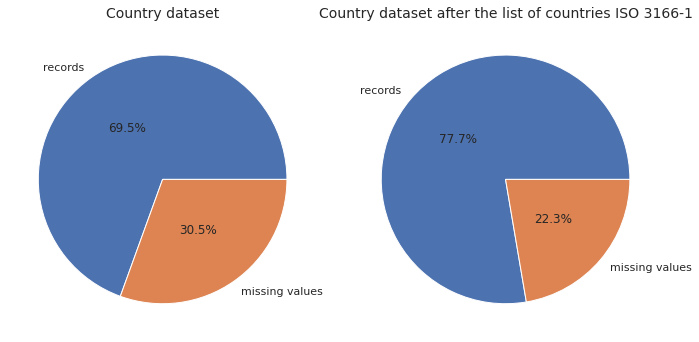

In [34]:
# Comparing missing values in Country dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country dataset", fontsize=14)

vals_ax2 = [prod(country_copy.shape)-country_copy.isna().sum().sum(), country_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

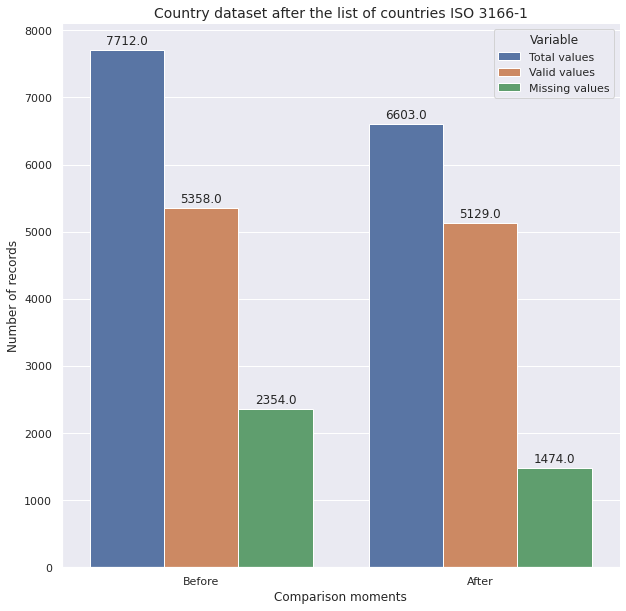

In [35]:
df_comparison = comparison_dfs(country, country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [36]:
df_initial_analysis(country_copy, "country copy")


Initial Analysis of country copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  213 rows and 31 columns
- Total of NaN values:            1474
- Percentage of NaN:              22.32 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      213
9                                           WB-2 code   object      213
2                                          Table Name   object      213
3                                           Long Name   object      213
4                                        2-alpha code   object      213
1                                          Short Name   object      213
15                        System of National Accounts  

In [37]:
country_copy.head(n=5)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,Budgetary central government,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2010.0,2012.0,2006
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,NaN,2011. Population figures compiled from adminis...,NaN,NaN,Yes,NaN,NaN,2006.0,NaN


### Cleaning **`"FootNote"`** dataset

In [38]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = foot_note_copy[~foot_note_copy["CountryCode"].isin(country_copy["Country Code"])]
df_print

,CountryCode,SeriesCode,Year,DESCRIPTION
7894,ARB,UIS.REPP.2.GPV.M,YR2006,UNESCO Institute for Statistics (UIS) estimate
7895,ARB,UIS.REPP.2.GPV.M,YR2007,UNESCO Institute for Statistics (UIS) estimate
7896,ARB,UIS.REPP.2.GPV.M,YR2008,UNESCO Institute for Statistics (UIS) estimate
7897,ARB,UIS.REPP.2.GPV.M,YR2011,UNESCO Institute for Statistics (UIS) estimate
7898,ARB,UIS.REPP.2.GPV.M,YR2014,UNESCO Institute for Statistics (UIS) estimate
...,...,...,...,...
635823,XKX,SP.POP.GROW,YR2017,5-year average value between 0s and 5s
635824,XKX,SP.POP.TOTL,YR2001,Interpolated between 2000 and 2005 assuming co...
635825,XKX,SP.POP.TOTL,YR2002,Interpolated between 2000 and 2005 assuming co...
635826,XKX,SP.POP.TOTL,YR2003,Interpolated between 2000 and 2005 assuming co...


In [39]:
# Filter "foot_note_copy" based on the list of "country_copy"
foot_note_copy = foot_note_copy[foot_note_copy["CountryCode"].isin(country_copy["Country Code"])]

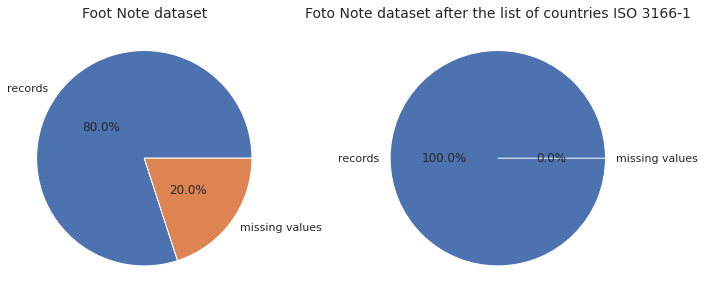

In [40]:
# Comparing missing values in Foot Note dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Foot Note dataset", fontsize=14)

vals_ax2 = [prod(foot_note_copy.shape)-foot_note_copy.isna().sum().sum(), foot_note_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Foto Note dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

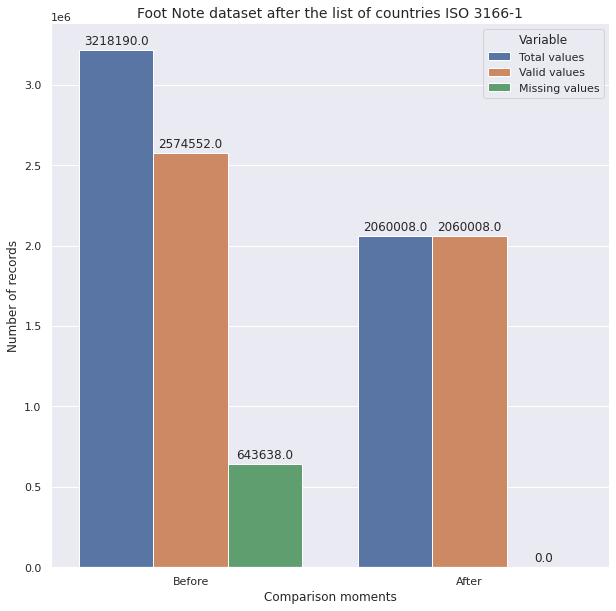

In [41]:
df_comparison = comparison_dfs(foot_note, foot_note_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Foot Note dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [42]:
df_initial_analysis(foot_note_copy, "foot note copy")


Initial Analysis of foot note copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  515002 rows and 4 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
          Name    Type  Records
0  CountryCode  object   515002
1   SeriesCode  object   515002
2         Year  object   515002
3  DESCRIPTION  object   515002


In [43]:
foot_note_copy.head(n=5)


,CountryCode,SeriesCode,Year,DESCRIPTION
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.


In [44]:
# Formatting columns year to work with it
foot_note_copy["Year"] = foot_note_copy["Year"].str.replace("YR", "")
foot_note_copy["Year"] = foot_note_copy["Year"].str.replace("yr", "")



In [45]:
foot_note_copy.head(n=5)

,CountryCode,SeriesCode,Year,DESCRIPTION
0,ABW,SE.PRE.ENRL.FE,2001,Country estimation.
1,ABW,SE.TER.TCHR.FE,2005,Country estimation.
2,ABW,SE.PRE.TCHR.FE,2000,Country estimation.
3,ABW,SE.SEC.ENRL.GC,2004,Country estimation.
4,ABW,SE.PRE.TCHR,2006,Country estimation.


### Cleaning **`"Country-Series"`** dataset

In [46]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = country_serie_copy[~country_serie_copy["CountryCode"].isin(country_copy["Country Code"])]
df_print

,CountryCode,SeriesCode,DESCRIPTION
84,CHI,SP.POP.TOTL,Data sources : United Nations World Population...
85,CHI,SP.POP.0014.TO.ZS,"Refers to Guernsey, and Jersey."
86,CHI,SP.POP.1564.TO.ZS,"Refers to Guernsey, and Jersey."
87,CHI,SP.POP.GROW,Data sources: United Nations World Population ...
88,CHI,SP.POP.TOTL.FE.ZS,"Refers to Guernsey, and Jersey."
89,CHI,SP.POP.TOTL.MA.ZS,"Refers to Guernsey, and Jersey."
392,NAM,SP.POP.GROW,Data sources: United Nations World Population ...
393,NAM,SP.POP.TOTL,Data sources : United Nations World Population...
597,XKX,SP.POP.TOTL,Data sources : World Bank's Kosovo coutnry off...
598,XKX,NY.GDP.MKTP.PP.KD,Estimates are based on regression.


In [47]:
# Filter "country_serie_copy" based on the list of "country_copy"
country_serie_copy = country_serie_copy[country_serie_copy["CountryCode"].isin(country_copy["Country Code"])]

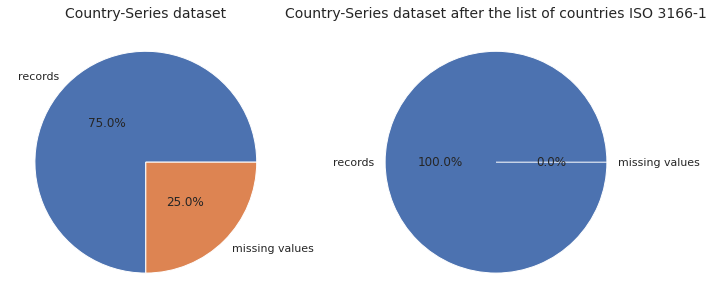

In [48]:
# Comparing missing values in Country-Series dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country-Series dataset", fontsize=14)

vals_ax2 = [prod(country_serie_copy.shape)-country_serie_copy.isna().sum().sum(), country_serie_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country-Series dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

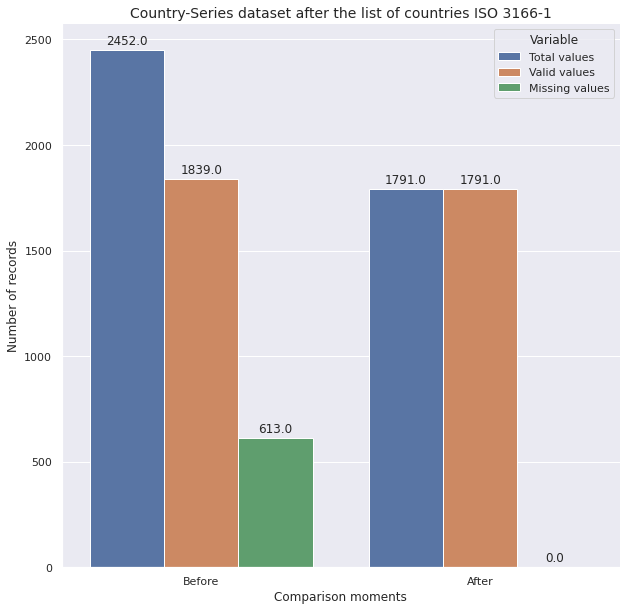

In [49]:
df_comparison = comparison_dfs(country_serie, country_serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
splot=sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country-Series dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [50]:
df_initial_analysis(country_serie_copy, "country-series copy")


Initial Analysis of country-series copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  597 rows and 3 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
          Name    Type  Records
0  CountryCode  object      597
1   SeriesCode  object      597
2  DESCRIPTION  object      597
